In [7]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [9]:
import pandas as pd

df = pd.read_csv("/content/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [11]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [12]:
747/4825

0.15481865284974095

In [13]:
df_spam= df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [14]:
df_ham= df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [15]:
df_ham_downsample = df_ham.sample(df_spam.shape[0])
# df_ham_downsample

In [16]:
df_ham_downsample.shape

(747, 2)

In [17]:
df_balanced = pd.concat([df_spam,df_ham_downsample])

In [18]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [19]:
df_balanced["spam"]=df_balanced["Category"].apply(lambda x: 1 if x=="spam" else 0)
df_balanced.sample(10)

,Category,Message,spam
3858,ham,No! But we found a diff farm shop to buy some ...,0
2438,spam,For ur chance to win £250 cash every wk TXT: P...,1
1002,spam,Please call our customer service representativ...,1
5273,ham,Its too late:)but its k.wish you the same.,0
4066,ham,Dont kick coco when he's down,0
54,spam,SMS. ac Sptv: The New Jersey Devils and the De...,1
2954,spam,"URGENT! Your mobile was awarded a £1,500 Bonus...",1
4605,ham,THANX 4 PUTTIN DA FONE DOWN ON ME!!,0
1483,ham,Ok...,0
1673,spam,URGENT! We are trying to contact U. Todays dra...,1


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [21]:
X_train.head(4)

2810    Oh yeah I forgot. U can only take 2 out shoppi...
5073    WIN a £200 Shopping spree every WEEK Starting ...
3255               I can make lasagna for you... vodka...
1809    Aiyo a bit pai seh ü noe... Scared he dun rem ...
Name: Message, dtype: object

In [22]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [23]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [25]:
len(X_train)

1120

In [26]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [27]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 24s 323ms/step - loss: 0.6154 - accuracy: 0.6652 - precision: 0.6565 - recall: 0.6929
Epoch 2/10
35/35 [==============================] - 11s 320ms/step - loss: 0.5038 - accuracy: 0.7937 - precision: 0.7943 - recall: 0.7929
Epoch 3/10
35/35 [==============================] - 13s 360ms/step - loss: 0.4350 - accuracy: 0.8562 - precision: 0.8494 - recall: 0.8661
Epoch 4/10
35/35 [==============================] - 11s 327ms/step - loss: 0.3964 - accuracy: 0.8839 - precision: 0.8733 - recall: 0.8982
Epoch 5/10
35/35 [==============================] - 12s 335ms/step - loss: 0.3690 - accuracy: 0.8821 - precision: 0.8639 - recall: 0.9071
Epoch 6/10
35/35 [==============================] - 12s 330ms/step - loss: 0.3498 - accuracy: 0.8848 - precision: 0.8735 - recall: 0.9000
Epoch 7/10
35/35 [==============================] - 12s 337ms/step - loss: 0.3238 - accuracy: 0.8991 - precision: 0.8795 - recall: 0.9250
Epoch 8/10
35/35 [================

In [28]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 305ms/step - loss: 0.2838 - accuracy: 0.9064 - precision: 0.9000 - recall: 0.9144


[0.2837788462638855,
 0.9064171314239502,
 0.8999999761581421,
 0.9144384860992432]

In [29]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 5s 319ms/step


In [31]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[168,  19],
       [ 16, 171]])

Text(50.722222222222214, 0.5, 'Truth')

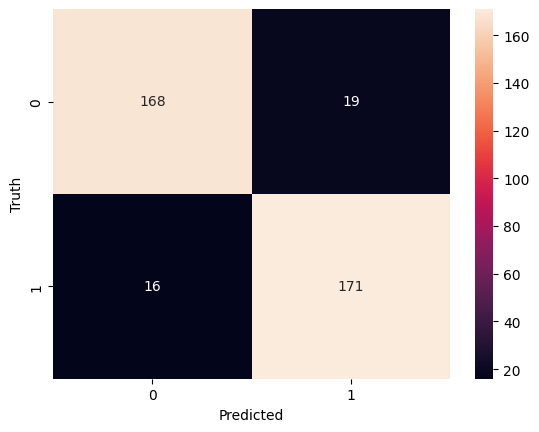

In [33]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [34]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       187
           1       0.90      0.91      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



In [35]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.74397665],
       [0.8197375 ],
       [0.75781435],
       [0.19501276],
       [0.11491422]], dtype=float32)